#### Setup

In [2]:
import model

import torchvision
import torchvision.transforms as transforms

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

import numpy as np
import math

%matplotlib inline

#### Load image

In [3]:
batch_size = 8

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize((32,32))])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False)

C:\ProgramData\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


#### Runtime prepare

In [5]:
# Display whether cuda detected
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("device selected:", device)

# Load to GPU
net = Net().to(device)  

device selected: cuda:0


#### Run NN

In [6]:
net.train_test(trainloader, testloader, batch_size, device, num_epochs = 5)

[1  5000] loss: 0.160
[2  5000] loss: 0.043
[3  5000] loss: 0.024
[4  5000] loss: 0.017
[5  5000] loss: 0.012
Finished Training


In [7]:
# Save model to PATH for future reference
PATH = './model_orginal'
torch.save(net, PATH)

## Overfitting analysis

Text(0.5, 1.0, 'Training accuracy vs number of epochs')

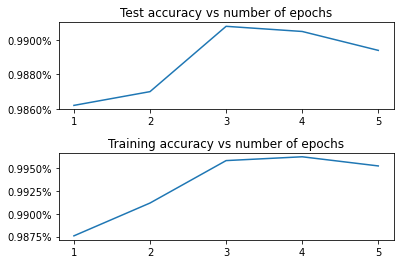

In [28]:
# Test accuracy vs number of epochs
plt.subplot(2, 1, 1)
plt.subplots_adjust(hspace = 0.5)
plt.plot(test_accuracy)
plt.xticks(np.arange(len(test_accuracy)), np.arange(1, len(test_accuracy)+1))
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.title('Test accuracy vs number of epochs')

# Training accuracy vs number of epochs
plt.subplot(2, 1, 2)   
plt.plot(train_accuracy)
plt.xticks(np.arange(len(train_accuracy)), np.arange(1, len(train_accuracy)+1))
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.title('Training accuracy vs number of epochs')

Text(0.5, 1.0, 'Training loss vs number of epochs')

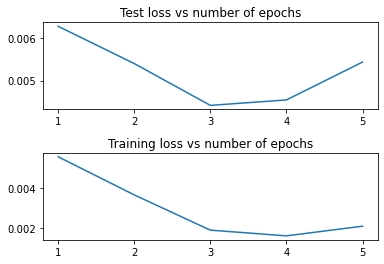

In [9]:
# Test loss vs number of epochs
plt.subplot(2, 1, 1)
plt.subplots_adjust(hspace = 0.5)
plt.plot(test_loss)
plt.xticks(np.arange(len(test_loss)), np.arange(1, len(test_loss)+1))
plt.title('Test loss vs number of epochs')

# Training loss vs number of epochs
plt.subplot(2, 1, 2)
plt.plot(train_loss)
plt.xticks(np.arange(len(train_loss)), np.arange(1, len(train_loss)+1))
plt.title('Training loss vs number of epochs')

## Robustness analysis
#### Setup

In [10]:
# Load model into net
PATH = './model_orginal'
model = torch.load(PATH, map_location=torch.device(device))
model = model.module.to(device)

# Get the test accuracy
def getAccuracy(model, testloader, batch_size):
    correct = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).to(device)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()

    return correct / (len(testloader) * batch_size)

#### Against Flip

In [11]:
# Random Horizontal Flip

batch_size = 4

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize((32,32)),
    transforms.RandomHorizontalFlip(p=1)])

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader_horiflip = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False)

horziontal_filp = (getAccuracy(model, testloader_horiflip, batch_size) * 100)
print('The accuracy for horizontal flip is %.2f%%' % horziontal_filp)

The accuracy for horizontal flip is 40.96%


In [12]:
# Random Vertical Flip

batch_size = 4

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize((32,32)),
    transforms.RandomVerticalFlip(p=1)])

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader_vertiflip = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False)

vertical_flip = (getAccuracy(model, testloader_vertiflip, batch_size) * 100)
print('The accuracy for Vertical flip is %.2f%%' % vertical_flip)

The accuracy for Vertical flip is 38.98%


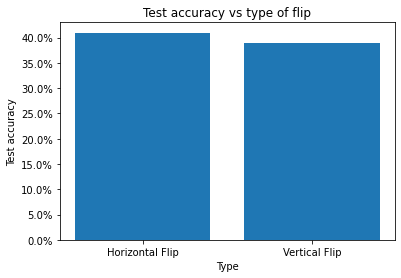

In [13]:
plt.bar(["Horizontal Flip", "Vertical Flip"],[horziontal_filp, vertical_flip])
plt.title('Test accuracy vs type of flip')
plt.xlabel('Type')
plt.ylabel('Test accuracy')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())

#### Against Gaussian Noise

In [14]:
# Random Gaussian Noise 0.01

batch_size = 4

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize((32,32)),
     transforms.Lambda(lambda x : x + 0.1*torch.randn_like(x))])

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader_gaussian_001 = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False)

gaussian_001 = (getAccuracy(model, testloader_gaussian_001, batch_size) * 100)
print('The accuracy for Random Gaussian Noise 0.01 is %.2f%%' % gaussian_001)

The accuracy for Random Gaussian Noise 0.01 is 98.31%


In [15]:
# Random Gaussian Noise 0.1

batch_size = 4

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize((32,32)),
     transforms.Lambda(lambda x : x + math.sqrt(0.1)*torch.randn_like(x))])

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader_gaussian_01 = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False)

gaussian_01 = (getAccuracy(model, testloader_gaussian_01, batch_size) * 100)
print('The accuracy for Random Gaussian Noise 0.1 is %.2f%%' % gaussian_01)

The accuracy for Random Gaussian Noise 0.1 is 95.06%


In [16]:
# Random Gaussian Noise 1

batch_size = 4

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize((32,32)),
     transforms.Lambda(lambda x : x + torch.randn_like(x))])

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader_gaussian_1 = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False)

gaussian_1 = (getAccuracy(model, testloader_gaussian_1, batch_size) * 100)
print('The accuracy for Random Gaussian Noise 1 is %.2f%%' % gaussian_1)

The accuracy for Random Gaussian Noise 1 is 55.63%


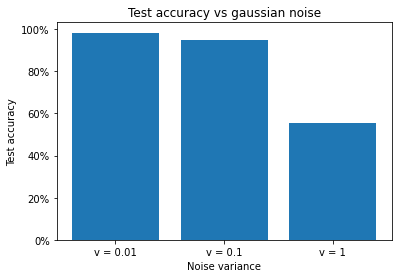

In [17]:
plt.bar(["v = 0.01", "v = 0.1", "v = 1"],[gaussian_001, gaussian_01, gaussian_1])
plt.title('Test accuracy vs gaussian noise')
plt.xlabel('Noise variance')
plt.ylabel('Test accuracy')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())